Open this [link](https://rl-lab.com/multi-armed-bandits/)

In [18]:
from abc import ABCMeta, abstractmethod, abstractproperty
import enum

import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import pandas

import matplotlib.pyplot as plt
%matplotlib inline

## Part 1. Bernoulli Bandit

We are going to implement several exploration strategies for simplest problem - bernoulli bandit.

The bandit has $K$ actions. Action produce 1.0 reward $r$ with probability $0 \le \theta_k \le 1$ which is unknown to agent, but fixed over time. Agent's objective is to minimize regret over fixed number $T$ of action selections:

$$\rho = T\theta^* - \sum_{t=1}^T r_t$$

Where $\theta^* = \max_k\{\theta_k\}$

**Real-world analogy:**

Clinical trials - we have $K$ pills and $T$ ill patient. After taking pill, patient is cured with probability $\theta_k$. Task is to find most efficient pill.

A research on clinical trials - https://arxiv.org/pdf/1507.08025.pdf

In [40]:
class BernoulliBandit:
  def __init__(self, n_actions=5):
    self._probs = np.random.random(n_actions)

  @property
  def action_count(self):
    return len(self._probs)

  def pull(self, action):
    if np.random.random() > self._probs[action]:
      return 0.0
    else: return 1.0
    
  def optimal_reward(self):
    return np.max(self._probs)

  def reset(self):
    self._probs = np.random.random(self.action_count)

  def step(self):
    pass

In [41]:
class AbstractAgent(metaclass=ABCMeta):
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0

    @abstractmethod
    def get_action(self):
        """
        Get current best action
        :rtype: int
        """
        pass

    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        if reward == 1:
          self._successes[action] += 1
        else:
          self._failures[action] += 1
        self._total_pulls += 1

    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):
    def get_action(self):
        return np.random.randint(0, len(self._failures))

### Epsilon-greedy agent

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\hat\theta_k \leftarrow \alpha_k / (\alpha_k + \beta_k)$

&nbsp;&nbsp; **end for**

&nbsp;&nbsp; $x_t \leftarrow argmax_{k}\hat\theta$ with probability $1 - \epsilon$ or random action with probability $\epsilon$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

Implement the algorithm above in the cell below:

In [42]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=0.01):
        self._epsilon = epsilon

    def get_action(self):
      actions = self._successes / (self._failures + self._successes + 1e-6)

      if np.random.random() >= self._epsilon:
        return np.argmax(actions) # exploitation
      else:
        return np.random.randint(0, len(self._successes)) # exploration


    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon)

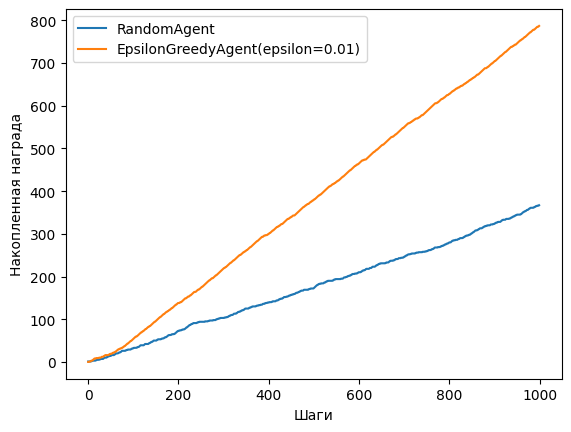

In [47]:

# Функция симуляции работы агента в среде
def run_simulation(bandit, agent, T=1000):
    agent.init_actions(bandit.action_count)
    
    rewards = []
    cumulative_reward = 0.0
    for t in range(T):
        action = agent.get_action()
        reward = bandit.pull(action)
        agent.update(action, reward)
        cumulative_reward += reward
        rewards.append(cumulative_reward)
    return rewards

# Пример запуска симуляции и визуализации результатов
T = 1000  # количество шагов симуляции
bandit = BernoulliBandit(n_actions=5)

# Создаем двух агентов: случайного и ε-жадного
agent_random = RandomAgent()
agent_epsilon = EpsilonGreedyAgent(epsilon=0.01)

# Запускаем симуляцию для первого агента
rewards_random = run_simulation(bandit, agent_random, T)
# При необходимости можно сбросить состояние бандита для нового эксперимента
bandit.reset()
rewards_epsilon = run_simulation(bandit, agent_epsilon, T)

# Строим график накопленной награды
plt.plot(rewards_random, label=agent_random.name)
plt.plot(rewards_epsilon, label=agent_epsilon.name)
plt.xlabel("Шаги")
plt.ylabel("Накопленная награда")
plt.legend()
plt.show()

### UCB Agent
Epsilon-greedy strategy have no preference for actions. It would be better to select among actions that are uncertain or have potential to be optimal. One can come up with idea of index for each action that represents optimality and uncertainty at the same time. One efficient way to do it is to use UCB1 algorithm:

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w_k \leftarrow \alpha_k / (\alpha_k + \beta_k) + \sqrt{2\log(t) \ / \ (\alpha_k + \beta_k)}$

&nbsp;&nbsp; **end for**

&nbsp;&nbsp; **end for**
 $x_t \leftarrow argmax_{k}w$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

__Note:__ in practice, one can multiply $\sqrt{2\log(t) \ / \ (\alpha_k + \beta_k)}$ by some tunable parameter to regulate agent's optimism and wilingness to abandon non-promising actions.

More versions and optimality analysis - https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf

In [48]:
class UCBAgent(AbstractAgent):
    def get_action(self):
        w = self._successes / (self._successes + self._failures + 1e-6) \
            + np.sqrt(2* np.log(self._total_pulls / (self._successes + self._failures + 1e-6)))
        return np.argmax(w)

In [49]:
from collections import OrderedDict

def get_regret(env, agents, n_steps=5000, n_trials=50):
    scores = OrderedDict({
        agent.name: [0.0 for step in range(n_steps)] for agent in agents
    })

    for trial in range(n_trials):
        env.reset()

        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()

            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward

            env.step()  # change bandit's state if it is unstationary

    for agent in agents:
        scores[agent.name] = np.cumsum(scores[agent.name]) / n_trials

    return scores

def plot_regret(agents, scores):
    for agent in agents:
        plt.plot(scores[agent.name])

    plt.legend([agent.name for agent in agents])

    plt.ylabel("regret")
    plt.xlabel("steps")

    plt.show()

/tmp/ipykernel_158117/3709844616.py:4: RuntimeWarning: divide by zero encountered in log
  + np.sqrt(2* np.log(self._total_pulls / (self._successes + self._failures + 1e-6)))
/tmp/ipykernel_158117/3709844616.py:4: RuntimeWarning: invalid value encountered in sqrt
  + np.sqrt(2* np.log(self._total_pulls / (self._successes + self._failures + 1e-6)))


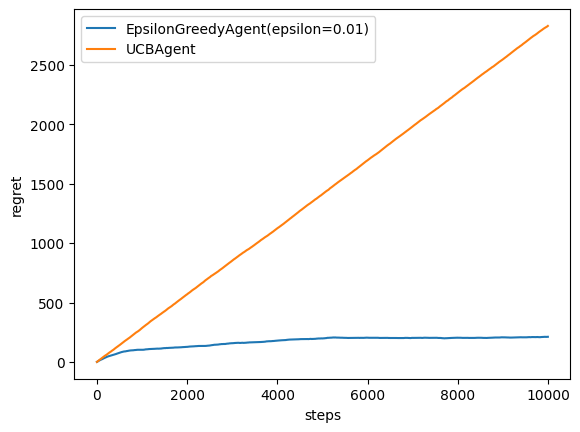

In [51]:
# Uncomment agents
agents = [
    EpsilonGreedyAgent(),
    UCBAgent(),
]

regret = get_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)
plot_regret(agents, regret)

### Bayesian Bandits
* The difference between previously studied algorithms and Bayesian bandits algorithm is that Bayesian makes assumption about reward distrobution *R*.

* Bayesian bandits alwasys exploits the proir knowledge ( ***p[R]*** ).
* At timestep ***t*** it calculate the posterior probability distribution by taking into account the observed reward by taking action ***a*** ( ***p[R | ht]  = (a1, r2), ..., (at-1,rt-1)*** ).
* **Note**: posterior knowledge at timestep ***t*** corresponds to proir knowledge at timestep ***t+1***   


We continue with Bandit exmaple. We define the inital proir distribution as [*Beta*](https://towardsdatascience.com/beta-distribution-intuition-examples-and-derivation-cf00f4db57af) distribution. the **α** represents the number of successes and **β** represents the number of failure. We update **α** and **β** if the machine wins or loses respectively.

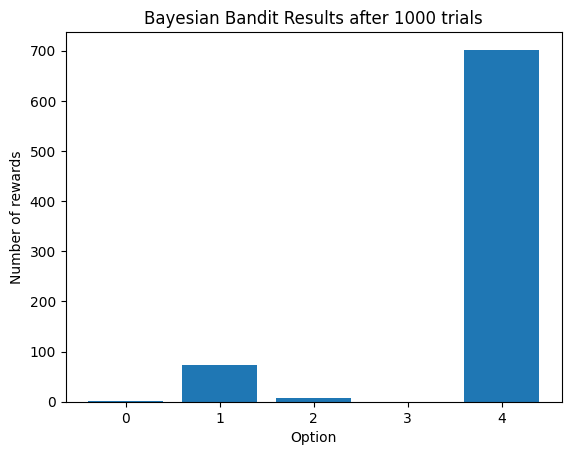

[0.1, 0.6, 0.3, 0.2, 0.8]


In [56]:
import numpy as np
import matplotlib.pyplot as plt

class BayesianBandit:
    def __init__(self, num_machines):
        self.num_machines = num_machines
        self.alpha = np.ones(num_machines)    # prior of 1 for each machine
        self.beta = np.ones(num_machines)     # prior of 0 for each machine
        self.real_winning_rate = [round(np.random.random(), 1) for _ in range(num_machines)] # the real winning rate of machines. #### THIS PART IS UNKOWN FOR THE AGENT.

    def choose_machine(self):
        theta = np.random.beta(self.alpha, self.beta)    # sample theta values from Beta distribution
        return np.argmax(theta)    # choose the machine with highest theta value

    def update(self, machine, reward):
        self.alpha[machine] += reward    # update alpha with reward
        self.beta[machine] += 1 - reward    # update beta with non-reward

    def take_action(self, machine):
        return 1 if self.real_winning_rate[machine] > np.random.random()  else 0

# Example usage:
num_machines = 5
num_trials = 1000
bandit = BayesianBandit(num_machines)
rewards = np.zeros(num_machines)

data = [] 
for i in range(num_trials):
    machine = bandit.choose_machine()
    # reward = np.random.binomial(1, 0.5)    # simulate reward with 50% probability
    reward = bandit.take_action(machine)
    rewards[machine] += reward
    bandit.update(machine, reward)
    if i % 50 == 0:
        # Сохраняем текущие параметры для каждой машины
        data.append( (i, 
                      (bandit.alpha[0], bandit.beta[0]),
                      (bandit.alpha[1], bandit.beta[1]),
                      (bandit.alpha[2], bandit.beta[2])
                     )
                   )
assets = ["red", "green", "blue"]
# Plot the results:
x = np.arange(num_machines)
plt.bar(x, rewards)
plt.title('Bayesian Bandit Results after {} trials'.format(num_trials))
plt.xlabel('Option')
plt.ylabel('Number of rewards')
plt.show()
# print([(a,b)for a,b in zip(bandit.alpha, bandit.beta)])
print(bandit.real_winning_rate)


### Visualization

In [57]:
import seaborn as sns
import scipy.stats as stats

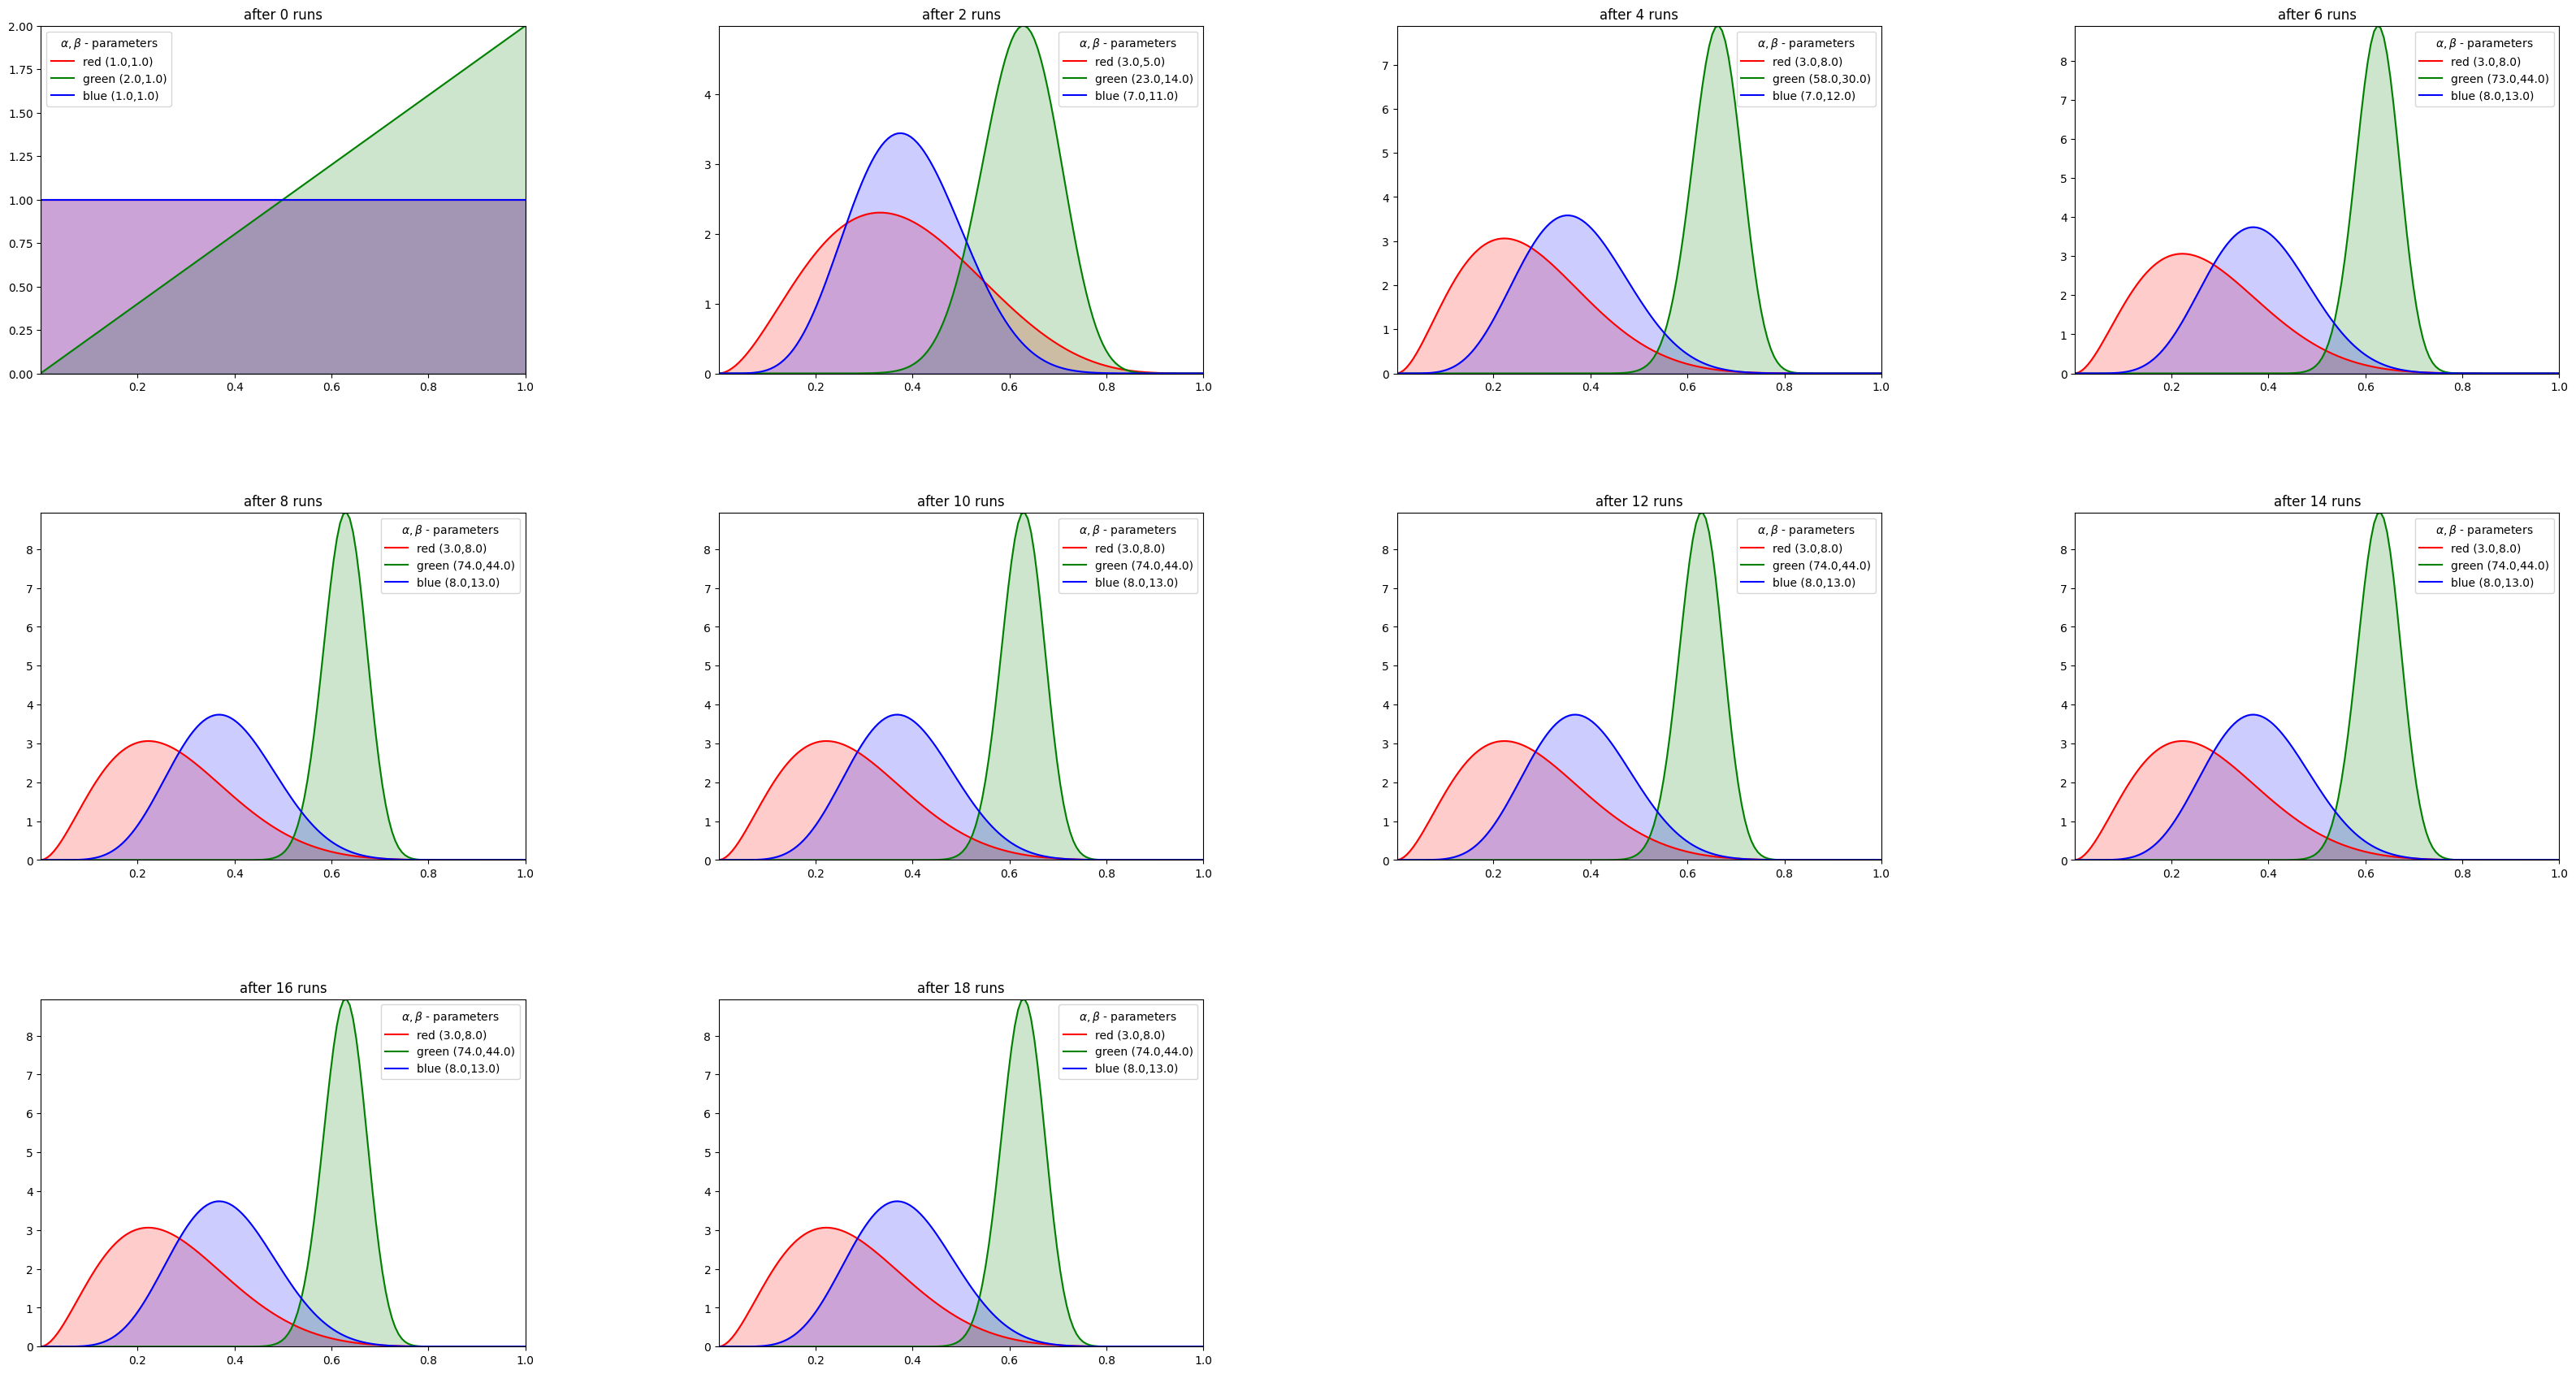

In [59]:
def plot_posteriors(priorR,priorG,priorB,ax=None,title=None):
    #fig = plt.figure(figsize=(12.5, 10))
    parameters = [priorR,priorG,priorB]
    x = np.linspace(0.001, 1, 150)
    for i, (alpha, beta) in enumerate(parameters):
        color = assets[i]
        y = stats.beta.pdf(x, alpha, beta)
        lines = sns.lineplot(x=x, y=y, label="%s (%.1f,%.1f)" % (color, alpha, beta), color = color,ax=ax)
        plt.fill_between(x, 0, y, alpha=0.2, color=color)
        if title:
            plt.title(title)
        plt.autoscale(tight=True)
    plt.legend(title=r"$\alpha, \beta$ - parameters")
    return plt


fig = plt.figure(figsize=(40, 60))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
cnt=1
for i in range(0,len(data),2):
    ax = fig.add_subplot(8, 4, cnt)
    g = plot_posteriors(*data[i][1:],ax,"after "+str(i)+" runs")
    cnt+=1
plt.show()